In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# You can write up to 20GB to the current directory (/kaggle/working
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U torchvision

     |████████████████████████████████| 23.3 MB 895 kB/s            
     |████████████████████████████████| 881.9 MB 6.1 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1


In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
import cv2
from PIL import Image
import albumentations as A
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.10.1+cu102
0.11.2+cu102


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

     |████████████████████████████████| 106 kB 905 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370022 sha256=a963397e7256772ef6bca600bc896a41cd12cc9b005650a53cfdaeb3bafe1f4c
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


## Transforms

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_albumentation(train):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(
        self,
        root: str,
        split = "train",
        transform= None,
        target_transform = None,
        transforms = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int):
        id = self.ids[index]
        image = self._load_image(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']
        new_boxes = []
        for box in boxes:
            xmin =  box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ["boxes"] = boxes
        targ["labels"] = torch.tensor([t["category_id"]  for t in target], dtype=torch.int64)
        targ["image_id"] = torch.tensor([t["image_id"]  for t in target])
        targ["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ["iscrowd"] = torch.tensor([t["iscrowd"]  for t in target], dtype=torch.int64)

        return image.div(255), targ


    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined/"

In [ ]:
coc = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coc.cats
n_classes = len(categories.keys())
n_classes, categories

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


(8,
 {0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
  1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
  2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
  3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
  4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
  5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
  6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
  7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}})

In [ ]:
classes = []
for i in categories.items():
    classes.append(i[1]["name"])

In [ ]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_albumentation(True))
val_dataset = AquariumDetection(root=dataset_path, split="valid", transforms=get_albumentation(False))
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_albumentation(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


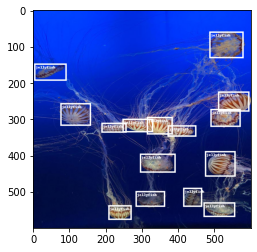

In [ ]:
sample = train_dataset[12]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int,
                               sample[1]['boxes'],
                               [classes[i] for i in sample[1]['labels']],
                               width=4).permute(1, 2, 0)
          )

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(447, 127, 63)

## Model

In [ ]:
## USE FASTERRCNN MOBILENET
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
# backbone = torchvision.models.detection.backbone_utils.mobilenet_backbone("mobilenet_v3_large", pretrained=True, fpn=True)
# anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator([[2, 3] for _ in range(6)], min_ratio=0.2, max_ratio=0.95)


In [ ]:
# ## Not working RETINANET ##
# backbone = torchvision.models.efficientnet_b0(pretrained=True).features
# backbone.out_channels = 1280
# anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
# model = models.detection.RetinaNet(backbone, num_classes=n_classes, min_size=600,
#                                    anchor_generator=anchor_generator)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
model.eval()
predictions = model(x)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [ ]:
from tqdm import tqdm

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.to(device)
    model.train()
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:6f}, loss_objectness: {:.6f}".format(
        epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses),
        all_losses_dict["loss_classifier"].mean(),
        all_losses_dict["loss_box_reg"].mean(),
        all_losses_dict["loss_rpn_box_reg"].mean(),
        all_losses_dict["loss_objectness"].mean(),
    ))



In [ ]:
# let's train it for 10 epochs
num_epochs = 7

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=28)
    lr_scheduler.step()

100%|██████████| 112/112 [00:18<00:00,  6.13it/s]


Epoch 0: lr: 0.010000 loss: 1.172548, loss_classifier: 0.600347, loss_box_reg: 0.443287, loss_rpn_box_reg: 0.030767, loss_objectness: 0.098147


100%|██████████| 112/112 [00:18<00:00,  6.05it/s]


Epoch 1: lr: 0.010000 loss: 0.830155, loss_classifier: 0.376361, loss_box_reg: 0.357119, loss_rpn_box_reg: 0.030753, loss_objectness: 0.065922


100%|██████████| 112/112 [00:18<00:00,  6.09it/s]


Epoch 2: lr: 0.010000 loss: 0.734436, loss_classifier: 0.314566, loss_box_reg: 0.330917, loss_rpn_box_reg: 0.028655, loss_objectness: 0.060298


100%|██████████| 112/112 [00:18<00:00,  5.98it/s]


Epoch 3: lr: 0.010000 loss: 0.699710, loss_classifier: 0.288422, loss_box_reg: 0.336514, loss_rpn_box_reg: 0.025648, loss_objectness: 0.049127


100%|██████████| 112/112 [00:17<00:00,  6.37it/s]


Epoch 4: lr: 0.010000 loss: 0.654049, loss_classifier: 0.252975, loss_box_reg: 0.336129, loss_rpn_box_reg: 0.024612, loss_objectness: 0.040334


100%|██████████| 112/112 [00:18<00:00,  6.04it/s]


Epoch 5: lr: 0.010000 loss: 0.686071, loss_classifier: 0.271232, loss_box_reg: 0.355630, loss_rpn_box_reg: 0.023877, loss_objectness: 0.035332


100%|██████████| 112/112 [00:17<00:00,  6.33it/s]

Epoch 6: lr: 0.010000 loss: 0.642563, loss_classifier: 0.243078, loss_box_reg: 0.341538, loss_rpn_box_reg: 0.023514, loss_objectness: 0.034432


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
img, _ = test_dataset[32]
img_int = torch.tensor(img * 255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

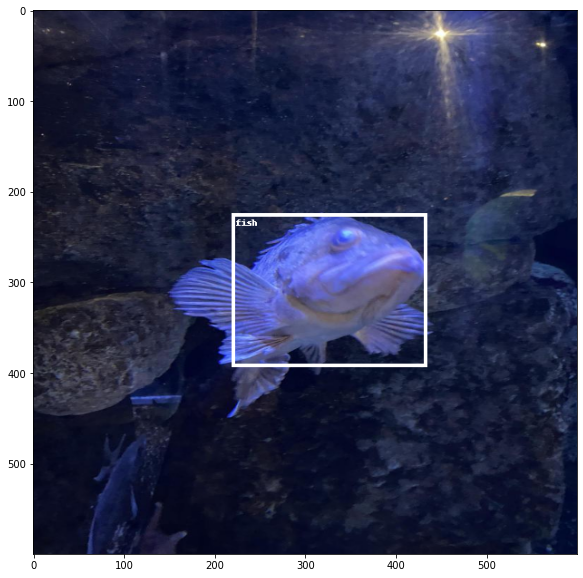

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
                               pred['boxes'][pred['scores'] > 0.8],
                               [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],
                               width=4).permute(1, 2, 0)
          )